This notebook describes how a NN was made using adaptive geohashing
Created 15/4/21 by Samy Van Vooren

In [1]:
from pygeo import encode
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt


In [2]:
datafile =  r"data.csv"
df = pd.read_csv(datafile)

zero_bathr = df["bathrooms"] == 0
zero_bedr = df["bedrooms"] == 0
df = df.drop(df[zero_bathr | zero_bedr].index)
df = df.drop(['id', 'date'],axis=1)


#ADDING THE GEOHASHED
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

padding = 0.0
(min_lat, max_lat) = ((1-padding)*df["lat"].min(),(1+padding)*df["lat"].max() )
(min_lon, max_lon) = ((1-padding)*df["long"].min(),(1+padding)*df["long"].max() )

geohashes = []

for row in df.iterrows():
    lat = row[1]["lat"]
    lon = row[1]["long"]
    string = encode(lat,lon,(min_lat, max_lat),(min_lon, max_lon),precision=2)
    geohashes.append(string)

#df.insert(len(list(df.columns)),"geohashes", geohashes, True) 
#am_diff_hashes = len(set(geohashes))

df = df.drop(['lat', 'long', 'zipcode'],axis=1)
values = np.array(geohashes)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

onehot_encoded = onehot_encoded.T
for i,col in enumerate(onehot_encoded):
    string = "h" + str(i)
    df[string] = [int(i) for i in col.tolist()]
print(df.head())

['bg' '9c' 'bc' ... 'de' 'de' 'ee']
      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  717000.0         3       1.00         1150      5000     1.0           0   
1  203000.0         3       1.75         1190      6000     1.0           0   
2  830000.0         4       3.00         2020      6000     1.0           0   
3  579000.0         3       2.75         2660    223027     1.0           0   
4  420000.0         4       2.75         2400     20000     1.0           0   

   view  condition  grade  ...  h409  h410  h411  h412  h413  h414  h415  \
0     0          3      8  ...     0     0     0     0     0     0     0   
1     0          3      7  ...     0     0     0     0     0     0     0   
2     0          3      8  ...     0     0     0     0     0     0     0   
3     0          3      8  ...     0     0     0     0     0     0     0   
4     0          3      8  ...     0     0     0     0     0     0     0   

   h416  h417  h418  
0     0   

In [3]:
#standardization scaler - fit&transform on train, fit only on test
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.iloc[:,1:]
y = df.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=101)

s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float))
print(X_test)

[[ 0.69559747  1.46877371  1.98403474 ... -0.00813358 -0.01150299
  -0.02152369]
 [-0.41607892 -0.80873703 -0.81009685 ... -0.00813358 -0.01150299
  -0.02152369]
 [-0.41607892 -0.80873703 -0.78835264 ... -0.00813358 -0.01150299
  -0.02152369]
 ...
 [ 0.69559747  0.49269768  0.01618331 ... -0.00813358 -0.01150299
  -0.02152369]
 [ 2.91895027  0.167339    0.94031243 ... -0.00813358 -0.01150299
  -0.02152369]
 [ 1.80727387  1.46877371  0.79897504 ... -0.00813358 -0.01150299
  -0.02152369]]


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import callbacks

neurons_per_layer = int(len(X_train[0]))
print("neurons per layer: ",neurons_per_layer)
model1 = Sequential()
model1.add(Dense(neurons_per_layer,activation='relu'))
model1.add(layers.Dropout(0.4))
model1.add(Dense(neurons_per_layer,activation='relu'))
model1.add(layers.Dropout(0.4))
model1.add(Dense(neurons_per_layer,activation='relu'))
model1.add(layers.Dropout(0.4))
model1.add(Dense(neurons_per_layer,activation='relu'))
model1.add(Dense(1))
model1.compile(optimizer='Adam',loss='mse')



neurons per layer:  434


In [6]:
es_callback = callbacks.EarlyStopping(monitor='val_loss', patience=20)
model1.fit(x=X_train,y=y_train,validation_data=(X_test, y_test),
          batch_size=128,epochs=400,verbose=0)


<AxesSubplot:>

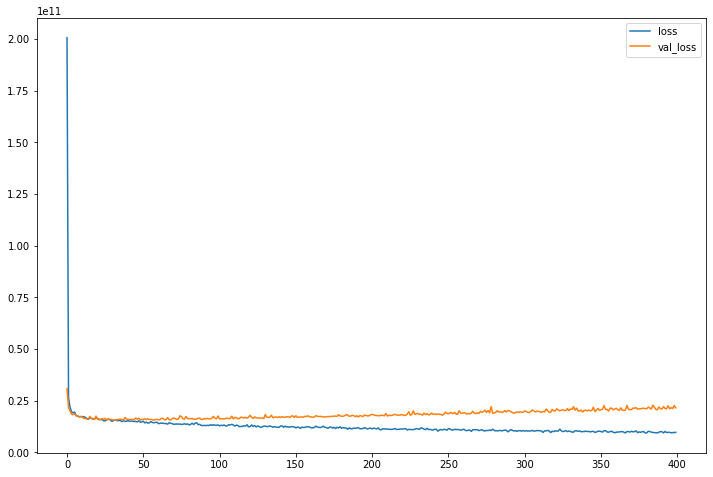

In [29]:
loss_df = pd.DataFrame(model1.history.history)
loss_df.plot(figsize=(12,8))
#loss_df.to_csv("models/geohash/no_latlong_no_zipcodes_g2/history.csv")

MAE: 78162.30425461105
MSE: 21492687986.472656
RMSE: 279.5752211026776
VarScore: 0.8483884970402251
r2:  0.8482654612296654


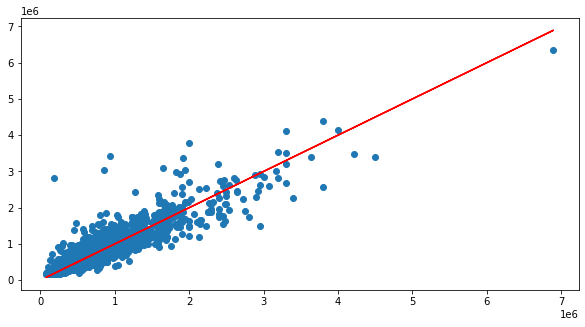

In [30]:
y_pred = model1.predict(X_test)

from sklearn import metrics

metrics_mae = metrics.mean_absolute_error(y_test, y_pred)
metrics_mse = metrics.mean_squared_error(y_test, y_pred)
metrics_mae_sqrt = np.sqrt(metrics.mean_absolute_error(y_test, y_pred))
metrics_evs =  metrics.explained_variance_score(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
print('MAE:', metrics_mae)  
print('MSE:', metrics_mse)  
print('RMSE:', metrics_mae_sqrt)
print('VarScore:',metrics_evs)
print('r2: ', r2)
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
ax = plt.scatter(y_test,y_pred)

# Perfect predictions
plt.plot(y_test,y_test,'r')

In [31]:
evaluation_csv = pd.read_csv("models/evaluation.csv")


name = 'ngh_4n36_0D'

metrics = [name, metrics_mae, metrics_mse, metrics_mae_sqrt, metrics_evs]
evaluation_csv.loc[-1] = metrics  # adding a row
evaluation_csv.index = evaluation_csv.index + 1  # shifting index
evaluation_csv = evaluation_csv.sort_index()  # sorting by index
evaluation_csv.sort_values("model")
evaluation_csv.to_csv("models/evaluation.csv", index=False)


In [274]:
evaluation_csv.sort_values("model")

,model,mean_absolute_error,mean_squared_error,mean_absolute_error.1,explained_variance_score
5,gh1_4n20_2D04,108127.010442,3.582990e+10,328.826718,0.767353
7,gh1_4n41_0D,92312.038888,2.276398e+10,303.828963,0.839291
6,gh1_4n41_2D04,98429.173037,2.863333e+10,313.734240,0.801210
8,gh1_4n82_0D,92077.471715,2.296784e+10,303.442699,0.837936
9,gh1_4n82_2D04,93825.845342,2.533949e+10,306.310048,0.822925
13,gh2_4n217_0D,72759.328589,1.614533e+10,269.739372,0.886434
12,gh2_4n217_2D04,72900.006841,1.638634e+10,270.000013,0.886287
4,gh2_4n217_3D04,72540.637266,1.599989e+10,269.333691,0.887315
10,gh2_4n434_0D,73380.181342,1.691260e+10,270.887765,0.881944
11,gh2_4n434_2D04,73012.213477,1.593602e+10,270.207723,0.888847
